In [165]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path




In [166]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

# Load Data

### Helper Functions

In [ ]:
ALL_LABELS = ["no_keypress", 'Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'Lalt', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'fn', 'tab', 'b', 'j', 'cmd', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'Ralt', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'asterisk', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'altL', 'altR', 'lcmd', 'delete']

def get_waveform(filepath):
    audio_binary = tf.io.read_file(filepath)
    audio = tf.squeeze(audio_binary)
    waveform, samplerate = tf.audio.decode_wav(audio)

    # Reduce to 1 channel by averaging
    waveform = tf.reduce_mean(waveform, axis=-1)
    
    if (samplerate != 44100):
        print("Incorrect sample rate: " + filepath)
    
    return waveform

# Encodes a list of instance labels into a binary vector
def multi_label_binary_encode_tensor(instance_labels):
    # Ensure instance_labels is a list (to handle both single and multi-label cases)
    if isinstance(instance_labels, str):
        instance_labels = [instance_labels]

    # Create a tensor of zeros with the same length as all_labels
    binary_vector = tf.zeros(len(ALL_LABELS), dtype=tf.int32)

    # Iterate through instance_labels and set corresponding indices to 1
    for label in instance_labels:
        if label in ALL_LABELS:
            index = ALL_LABELS.index(label)
            binary_vector = tf.tensor_scatter_nd_update(
                binary_vector, indices=[[index]], updates=[1]
            )
    
    return binary_vector

def multi_label_binary_decode_tensor(binary_vector):
    binary_vector = binary_vector.numpy()
    decoded_labels = [ALL_LABELS[i] for i, val in enumerate(binary_vector) if val == 1]
    return decoded_labels

print(multi_label_binary_encode_tensor("no_keypress"))
print(multi_label_binary_encode_tensor(["no_keypress", "p", "g"]))
print(multi_label_binary_decode_tensor(multi_label_binary_encode_tensor(["no_keypress", "p", "g"])))


tf.Tensor(
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(72,), dtype=int32)
tf.Tensor(
[1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(72,), dtype=int32)


NameError: name 'all_labels' is not defined

### MKA Dataset Functions


In [ ]:
def get_MKA_waveforms_and_labels():
    datasetPath = "./MKA datasets"

    excluded_classes = ["start", "menu", "pgdn", "pgup", "home", "neshanay xwarawa", "neshanay sarawa", "neshanay lay rast", "neshanay lay chap"]

    mkaWaveforms= []
    mkaLabels= []
    unique_cases = []

    for manufacturer in os.listdir(datasetPath):
        wavChildFolderPath = datasetPath + "/" + manufacturer + "/Sound Segment(wav)"
        caseFolders = os.listdir(wavChildFolderPath)
        
        for case in caseFolders:
            if case not in excluded_classes:
                for file in os.listdir(wavChildFolderPath + "/" + case):
                    wf = get_waveform(wavChildFolderPath + "/" + case + "/" + file)
                    mkaWaveforms.append(wf)
                    mkaLabels.append(case)
                    # print(wavChildFolderPath + "/" + case + "/" + file)
                
                if case not in unique_cases:
                    unique_cases.append(case)
    
    if len(mkaWaveforms) != len(mkaLabels):
        print("Filepaths and Labels do not match")
        return None, None

    print("Cases: ", unique_cases)
    return mkaWaveforms, mkaLabels


# Split audio data into windows
# frame_length: Number of samples per frame (50ms for 44100 Hz = 2205)
# frame_step: Number of samples to step between frames (50% overlap = 2205 // 2 = 1102)
def split_into_50ms_windows(waveform, frame_length=2205, frame_step=1102): # 50ms windows with 50% overlap
    print("Waveform shape before framing:", waveform.shape)
    frames = tf.signal.frame(waveform, frame_length=frame_length, frame_step=frame_step)
    print("Frames shape after framing (with overlap):", frames.shape)
    return frames

# Filters out frames with insignificant signals and labels them as "no_keypress".
def filter_insignificant_frames(frames, labels, threshold=0.05):
    # Compute the max amplitude for each frame
    frame_amplitudes = tf.reduce_max(tf.abs(frames), axis=-1)

    # Identify frames with insignificant signals
    insignificant_mask = frame_amplitudes <= threshold

    # Assign "no_keypress" to insignificant frames
    labels = tf.where(insignificant_mask, "no_keypress", labels)

    return frames, labels

# Split and label data according to 50ms sample amplitude on clean data
def preprocess_waveform_and_label(waveform, label, threshold=0.05):

    tf.debugging.assert_equal(
        tf.shape(waveform)[0], 
        tf.constant(44100, dtype=tf.int32),
        message="Waveform must have 44100 samples"
    )

    # Split waveform into frames
    frames = split_into_50ms_windows(waveform)

    # Detect keypress in each frame
    def detect_keypress(frame):
        return tf.reduce_max(tf.abs(frame)) > threshold

    keypress_mask = tf.map_fn(
        detect_keypress,
        frames,
        fn_output_signature=tf.bool
    )

    # Assign labels per frame
    labels = tf.where(keypress_mask, label, "no_keypress")

    # Relabel insignificant frames as "no_keypress"
    frames, labels = filter_insignificant_frames(frames, labels, threshold=0.15)

    # Debugging
    print("Frames shape:", frames.shape)  # Should match (num_frames, frame_length)
    print("Labels shape:", labels.shape)  # Should match (num_frames,)

    return frames, labels



### Supplementary Dataset Functions

In [169]:
def get_supp_waveforms_and_labels():
    return [], []

### Preprocessing Data

In [170]:
# Load MKA
mka_waveforms, mka_labels = get_MKA_waveforms_and_labels()

# Load supplementary
sup_waveforms, sup_labels = get_supp_waveforms_and_labels()

# Splice
waveforms = mka_waveforms + sup_waveforms
labels = mka_labels + sup_labels


# print("Number of audio samples: ", len(waveforms))

train_files = waveforms
val_files = ""
test_files = ""

# Verify length of audios is 1 second at 44100 Hz
for i, tr_f in enumerate(train_files):
    num_samples = tf.shape(tr_f)[0]  # Length along the first dimension (number of samples)
    # num_channels = tf.shape(tr_f)[1] # Length along the second dimension (number of channels)
    if (num_samples != 44100):
        print(f"Waveform {i}: num_samples = {num_samples}")



# Map the preprocessing function to the dataset
waveform_and_label_ds = tf.data.Dataset.from_tensor_slices((waveforms, labels))

flattened_ds = waveform_and_label_ds.map(
    lambda waveform, label: tf.data.Dataset.from_tensor_slices(preprocess_waveform_and_label(waveform, label)),
    num_parallel_calls=tf.data.AUTOTUNE
).flat_map(lambda x: x)

flattened_ds.cache()

print(flattened_ds.element_spec)


Cases:  ['Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'Lalt', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'fn', 'tab', 'b', 'j', 'cmd', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'Ralt', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'asterisk', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'altL', 'altR', 'lcmd', 'delete']
Waveform shape before framing: (44100,)
Frames shape after framing (with overlap): (39, 2205)
Frames shape: (39, 2205)
Labels shape: (39,)
(TensorSpec(shape=(2205,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


# Data Visualization

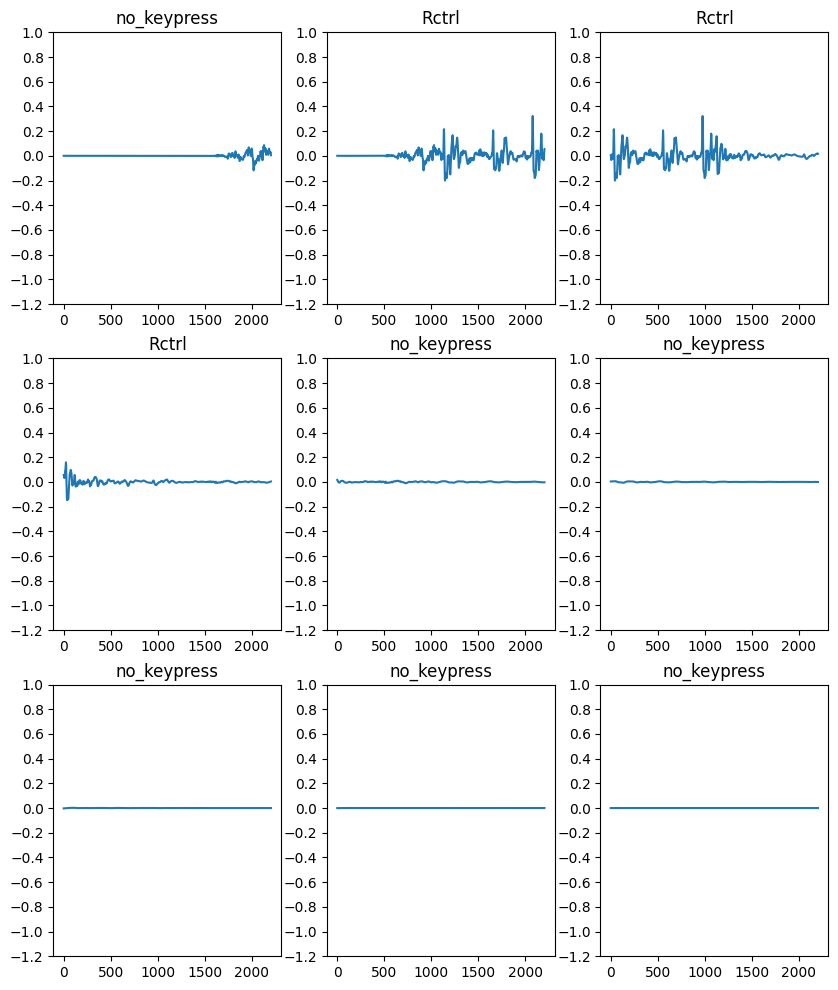

In [ ]:
def plot_raw_audio_samples():
    # Plot raw audio
    rows = 3
    cols = 3
    n = rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

    # Dataset with no no_keypress labels
    sample_ds = flattened_ds.take(10000)  # Limit the size to 1000 elements
    filtered_ds = sample_ds.filter(lambda frame, label: label != "no_keypress")

    for i, (frame, label) in enumerate(sample_ds.take(n)):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(frame.numpy())  # Plot individual frames
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        label = label.numpy().decode('utf-8') if isinstance(label.numpy(), bytes) else label.numpy()
        ax.set_title(label)

    plt.show()


plot_raw_audio_samples()

# Spectrogram Generation

In [172]:
def waveform_to_spectrogram(waveform, label, frame_length=1024, frame_step=256):
    spectrogram = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)  # Convert complex values to magnitude
    return spectrogram, label